# KSA: Polar Observations and Modelling

# Week 7 - A model experiment to study future changes

<div style="float: right; margin-right: 20px; margin-left: 30px; width: 30%; max-width: 500px;">
    <img src="images/ssp_emissions.png" width="100%"/>
</div>

One of the wonderful, fun things that numerical models can be used for is to run experiments - in analogy to a lab experiment, a numerical experiment allows us to vary the model's conditions and study the impacts of such variation. Particularly, model's are widely used to study projected changes associated to different pathways of CO$_2$ emissions, the most well known of them being model's part of the Coupled Model Intercomparison Project (CMIP) that inform the Intergovernmental Panel on Climate Change (IPCC) reports. CMIP models have a coupled atmosphere, ocean and sea ice, making them quite expensive to run and producing very large outputs - which is why their resolution is not very high and there is a spectrum of processes they don't represent, particularly the introduction of freshwater into the ocean from melting ice sheets. 

A way to expand on the collective effort of CMIP is to use the atmospheric output from their projections to force a model like ACCESS-OM2 that has a higher resolution at the expense of not having an atmosphere. This week we are going to use one of those experiments that uses the CMIP6 projections for the SSP585 pathway, used in the work of [Dawson et al. 2024](). The Shared Socioeconomic Pathways (SSPs) are different possible pathways of emissions (you can see them on the figure on the right), that range from a future in which decide to actively remove anthropogenic carbon from the atmosphere (the blue lines) to futures in which we continue with "business-as-usual" emissions, no reductions (the red lines).

## Model simulations

In the past week we have worked with output from ACCESS-OM2 at it's lowest resolution (1$^{\circ}$), from what we call an Interanually Forced simulation - which basically means we are forcing the model with a complete, interannually varying atmosphere from 1958 to 2018. This means we have the full spectrum of atmospheric variability in the forcing, which makes isolating the effect of a single component, like looking just at the effect of temperature or just at the effect of westerly winds, almost impossible. 

A simpler way of isolating cause and effect is to use a simulation that is run with just one year of atmospheric forcing, cycling it continuously in what is called a Repeat Year Forcing simulation. The year is chosen for being a vainilla year, with nothing especially out of the ordinary happen. We will call these our **CONTROL** simulation, and it will constitute our reference point.

### Perturbation experiments

[Dawson et al. (2024)]() then used the output from CMIP models corresponding to different emissions scenarios (we will only look at the SSP585 one) and run simulations forcing the model with what the atmospheric wind and thermal changes would look like at end of the century. They also ran an additional simulation increasing meltwater input using projections from [Golledge et al. (2019)](https://www.nature.com/articles/s41586-019-0889-9). In this class we will look at how the ocean responded to the perturbations.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cm
import glob
import gsw
import matplotlib.lines as mlines
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import metpy
import numpy as np
import xarray as xr
import xarrayMannKendall as xrmk

In [2]:
def stereographic_axis(ax):
    
    ax.set_extent([-180, 180, -80, -50], crs = ccrs.PlateCarree())
    ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='gainsboro',
                                            facecolor='gainsboro'))
    ax.coastlines(resolution = "110m")
    # Map the plot boundaries to a circle
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    return ax

## Perturbation forcing fields 

Let's look at the forcing fields for the perturbation simulations in this work. This will help us understand and interpret what we see in the simulations. 

The forcing fields were built by looking at the atmosphere in CMIP6 models, at the end of the century, for the SSP585 scenario. These "future atmospheric state" was used to force the ACCESS-OM2-01 model. There are two perturbation simulations:

1. Wind + thermal + precipitation: changes to surface winds, temperatures and precipitation where accounted for
2. Wind + thermal + precipitation + meltwater: in addition to the above, changes to ice sheet melt and freshwater input into the ocean were included.

The perturbation simulations are "branched" from the **CONTROL** simulation (the one forced with the vainilla atmospheric year on repeat). The process of branching is illustrated in the (very crude) schematic bellow. Note how the control (in black) and the perturbation simulations (red and orange) are run in parallel, which allows us to compare between simulations and understand what the changes to the forcing drive:

<div align="center",style="max-width: 500px;">
    <img src="images/perturbation_sims.png" width="40%" />
</div>

We will start by working with the wind+thermal+precipitation simulation. We will leave the simulation with meltwater for the next class.

### Load forcing field data

Let's open the atmospheric forcing fields for the control simulation, and the perturbation simulations. 

To open the files, we can use `xr.open_mfdataset` which opens and merges separate netcdf files. We need to provide the paths of the files:

In [3]:
paths_control = glob.glob('/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class7/data/forcing_fields/control*.nc') 
paths_control

['/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class7/data/control_rlds.nc',
 '/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class7/data/control_t_10.nc',
 '/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class7/data/control_snow.nc',
 '/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class7/data/control_u_10.nc',
 '/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class7/data/control_v_10.nc',
 '/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class7/data/control_rain.nc',
 '/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class7/data/control_q_10.nc']

In [4]:
control = xr.open_mfdataset(paths_control)

In [5]:
control

<xarray.Dataset> Size: 17MB
Dimensions:    (time: 12, latitude: 80, longitude: 640)
Coordinates:
  * latitude   (latitude) float64 640B -89.57 -89.01 -88.45 ... -45.77 -45.21
  * longitude  (longitude) float64 5kB 0.0 0.5625 1.125 ... 358.3 358.9 359.4
  * time       (time) object 96B 1900-01-31 00:00:00 ... 1900-12-31 00:00:00
Data variables:
    huss_10m   (time, latitude, longitude) float32 2MB dask.array<chunksize=(12, 80, 640), meta=np.ndarray>
    prrn       (time, latitude, longitude) float32 2MB dask.array<chunksize=(12, 80, 640), meta=np.ndarray>
    prsn       (time, latitude, longitude) float32 2MB dask.array<chunksize=(12, 80, 640), meta=np.ndarray>
    rlds       (time, latitude, longitude) float32 2MB dask.array<chunksize=(12, 80, 640), meta=np.ndarray>
    tas_10m    (time, latitude, longitude) float32 2MB dask.array<chunksize=(12, 80, 640), meta=np.ndarray>
    uas_10m    (time, latitude, longitude) float32 2MB dask.array<chunksize=(12, 80, 640), meta=np.ndarray>
    vas_10m    (time, latitude, longitude) float32 2MB dask.array<chunksize=(12, 80, 640), meta=np.ndarray>
Attributes:
    title:        Adjusted 10 m specific humidity of JRA55-do
    institution:  JMA Meteorological Research Institute
    comment:      None
    version:      v1.3
    fill_value:   Fill value is -9.99e33

In [6]:
paths_perturb = glob.glob('/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class7/data/forcing_fields/perturbation*.nc') 
paths_perturb

['/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class7/data/perturbation_q_10.nc',
 '/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class7/data/perturbation_v_10.nc',
 '/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class7/data/perturbation_rain.nc',
 '/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class7/data/perturbation_t_10.nc',
 '/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class7/data/perturbation_rlds.nc',
 '/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class7/data/perturbation_u_10.nc',
 '/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class7/data/perturbation_snow.nc']

In [7]:
perturbation = xr.open_mfdataset(paths_perturb)

In [8]:
perturbation

<xarray.Dataset> Size: 32MB
Dimensions:    (time: 12, latitude: 80, longitude: 640)
Coordinates:
  * latitude   (latitude) float64 640B -89.57 -89.01 -88.45 ... -45.77 -45.21
  * longitude  (longitude) float64 5kB 0.0 0.5625 1.125 ... 358.3 358.9 359.4
  * time       (time) object 96B 1900-01-31 00:00:00 ... 1900-12-31 00:00:00
Data variables:
    huss_10m   (time, latitude, longitude) float32 2MB dask.array<chunksize=(12, 80, 640), meta=np.ndarray>
    prrn       (time, latitude, longitude) float64 5MB dask.array<chunksize=(12, 80, 640), meta=np.ndarray>
    prsn       (time, latitude, longitude) float64 5MB dask.array<chunksize=(12, 80, 640), meta=np.ndarray>
    rlds       (time, latitude, longitude) float64 5MB dask.array<chunksize=(12, 80, 640), meta=np.ndarray>
    tas_10m    (time, latitude, longitude) float64 5MB dask.array<chunksize=(12, 80, 640), meta=np.ndarray>
    uas_10m    (time, latitude, longitude) float64 5MB dask.array<chunksize=(12, 80, 640), meta=np.ndarray>
    vas_10m    (time, latitude, longitude) float64 5MB dask.array<chunksize=(12, 80, 640), meta=np.ndarray>
Attributes:
    title:        Adjusted 10 m specific humidity of JRA55-do
    institution:  JMA Meteorological Research Institute
    comment:      None
    version:      v1.3
    fill_value:   Fill value is -9.99e33

#### Question 1

What variables are included in our forcing field files?

*Answer here*

Let's start by looking at zonal and meridional winds. We will plot the CONTROL forcing fields, and the anomalies applied (perturbation forcing fields *minus* control):

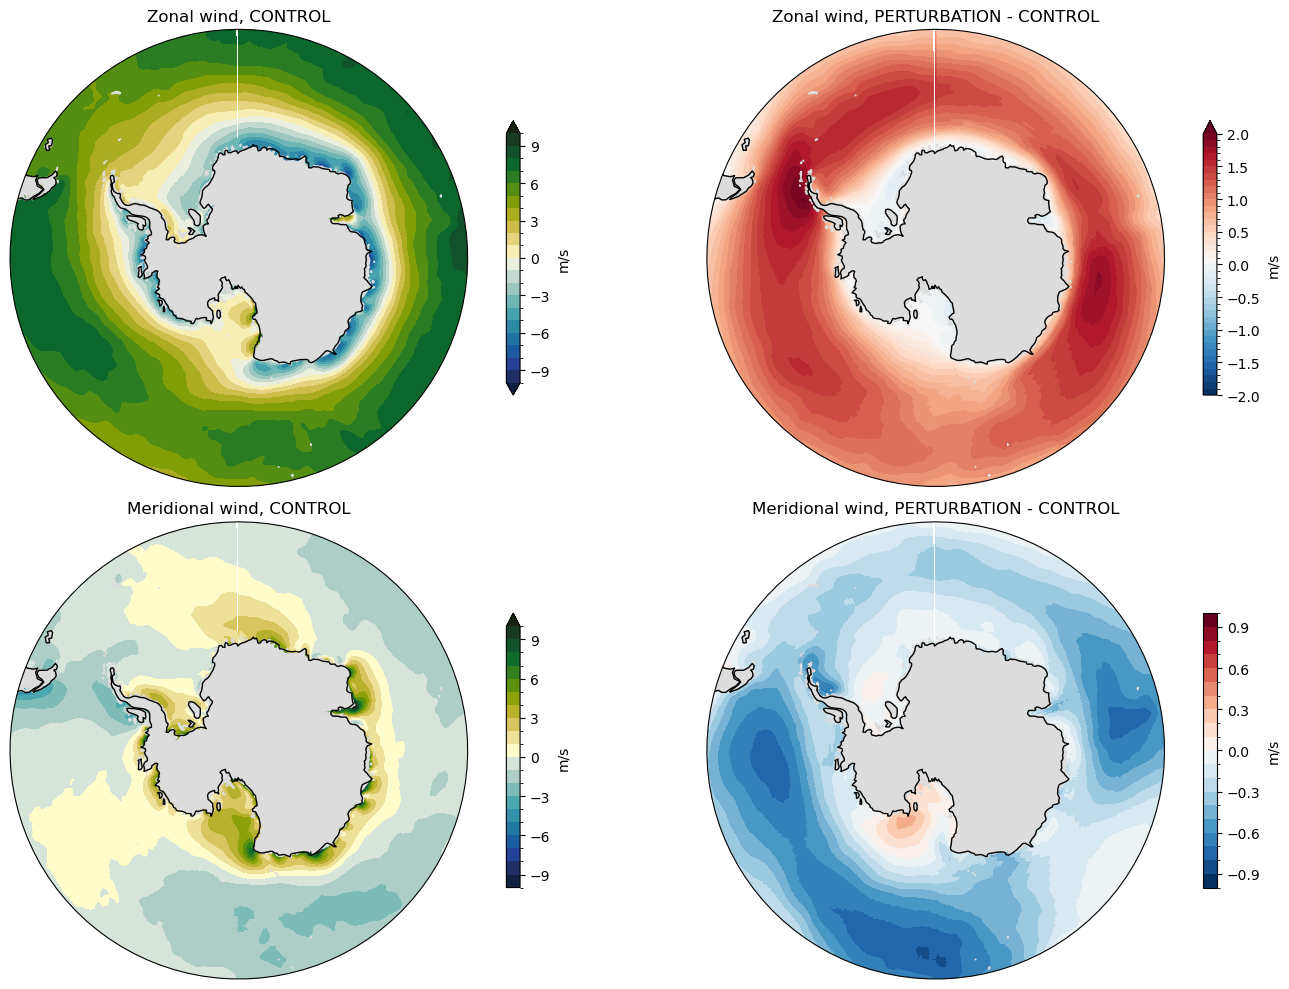

In [41]:
fig = plt.figure(figsize = (15, 10))
axs = [fig.add_subplot(221, projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(222, projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(223, projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(224, projection = ccrs.SouthPolarStereo())]
for ax in axs:
    ax = stereographic_axis(ax)

control['uas_10m'].mean('time').plot.contourf(ax = axs[0], levels = np.arange(-10, 11, 1),
                                             cmap = cm.cm.delta, transform = ccrs.PlateCarree(),
                                             cbar_kwargs = {'label':'m/s', 'shrink':0.6})
axs[0].set_title('Zonal wind, CONTROL');

(perturbation['uas_10m'] - control['uas_10m']).mean('time').plot.contourf(ax = axs[1], levels = np.arange(-2, 2.1, .1),
                                                                          cmap = 'RdBu_r', transform = ccrs.PlateCarree(),
                                                                          cbar_kwargs = {'label':'m/s', 'shrink':0.6})
axs[1].set_title('Zonal wind, PERTURBATION - CONTROL');

control['vas_10m'].mean('time').plot.contourf(ax = axs[2], levels = np.arange(-10, 11, 1),
                                             cmap = cm.cm.delta, transform = ccrs.PlateCarree(),
                                             cbar_kwargs = {'label':'m/s', 'shrink':0.6})
axs[2].set_title('Meridional wind, CONTROL');

(perturbation['vas_10m'] - control['vas_10m']).mean('time').plot.contourf(ax = axs[3], levels = np.arange(-1, 1.1, .1),
                                                                          cmap = 'RdBu_r', transform = ccrs.PlateCarree(),
                                                                          cbar_kwargs = {'label':'m/s', 'shrink':0.6})
axs[3].set_title('Meridional wind, PERTURBATION - CONTROL');

plt.tight_layout();

Note how the surface wind fields in the Southern Ocean are dominated by the zonal component - the magnitude of the zonal wind (top left) is way larger than that of the meridional wind (bottom left). 

In out perturbations, the red colors in the top right panel indicate an overall strengthening of the westerly winds, and a weakening of the near shore easterly winds (the blue, negative areas in top left). This is overall interpreted as a strengthening and shifting south of the westerly wind belt. 

The meridional perturbations are smaller in magnitude, and overall show an increase in the southward winds over most of the Southern ocean, and a small region of increased off-shore winds on the Ross Sea.

Let's look at what the changes in surface temperature look like:

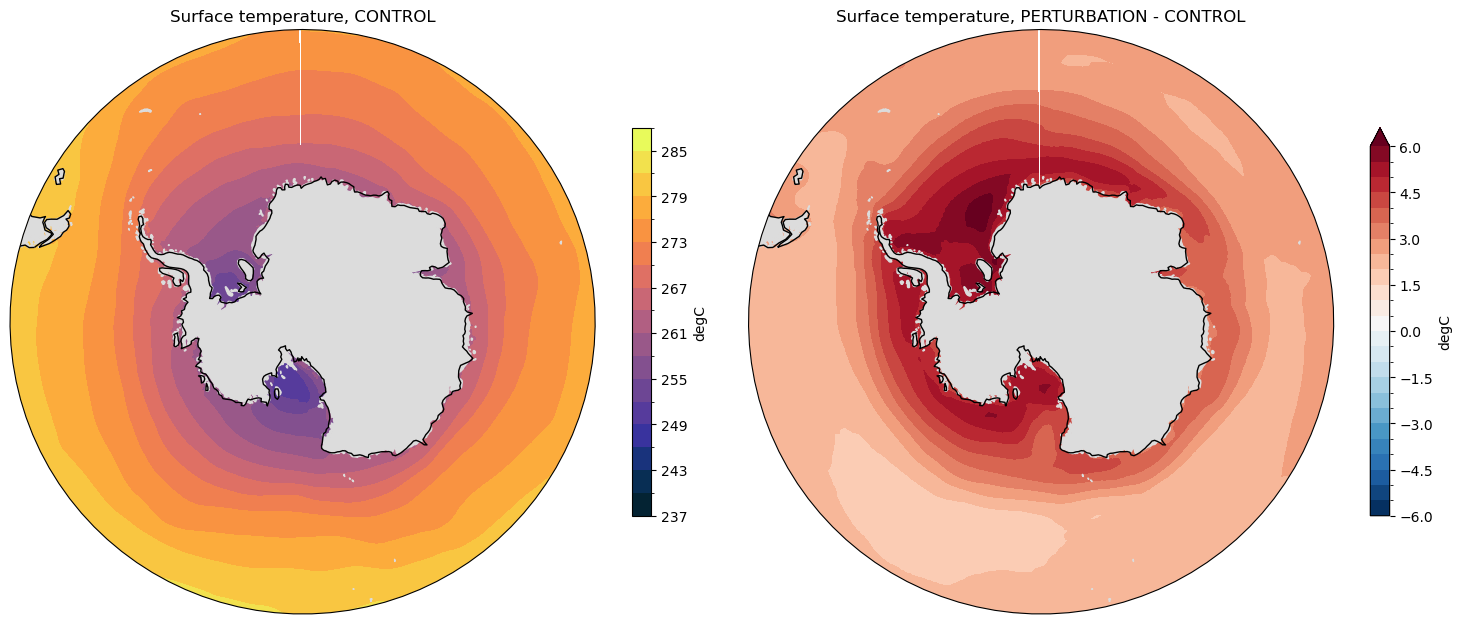

In [9]:
fig = plt.figure(figsize = (15, 10))
axs = [fig.add_subplot(121, projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(122, projection = ccrs.SouthPolarStereo())]
for ax in axs:
    ax = stereographic_axis(ax)

control['tas_10m'].mean('time').plot.contourf(ax = axs[0], levels = 20,
                                             cmap = cm.cm.thermal, transform = ccrs.PlateCarree(),
                                             cbar_kwargs = {'label':'degC', 'shrink':0.4})
axs[0].set_title('Surface temperature, CONTROL');

(perturbation['tas_10m']-control['tas_10m']).mean('time').plot.contourf(ax = axs[1], levels = np.arange(-6, 6.5, .5),
                                                                        cmap = 'RdBu_r', transform = ccrs.PlateCarree(),
                                                                        cbar_kwargs = {'label':'degC', 'shrink':0.4})
axs[1].set_title('Surface temperature, PERTURBATION - CONTROL');

plt.tight_layout();

#### Question 2

There is something wrong in our plots. Correct it.

*Answer here*

In [26]:
control['rlds']

<xarray.DataArray 'rlds' (time: 12, latitude: 80, longitude: 640)> Size: 2MB
dask.array<open_dataset-rlds, shape=(12, 80, 640), dtype=float32, chunksize=(12, 80, 640), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 640B -89.57 -89.01 -88.45 ... -45.77 -45.21
  * longitude  (longitude) float64 5kB 0.0 0.5625 1.125 ... 358.3 358.9 359.4
  * time       (time) object 96B 1900-01-31 00:00:00 ... 1900-12-31 00:00:00
Attributes:
    units:          W/m2
    long_name:      Surface Downwelling Longwave Radiation
    standard_name:  surface_downwelling_longwave_flux_in_air

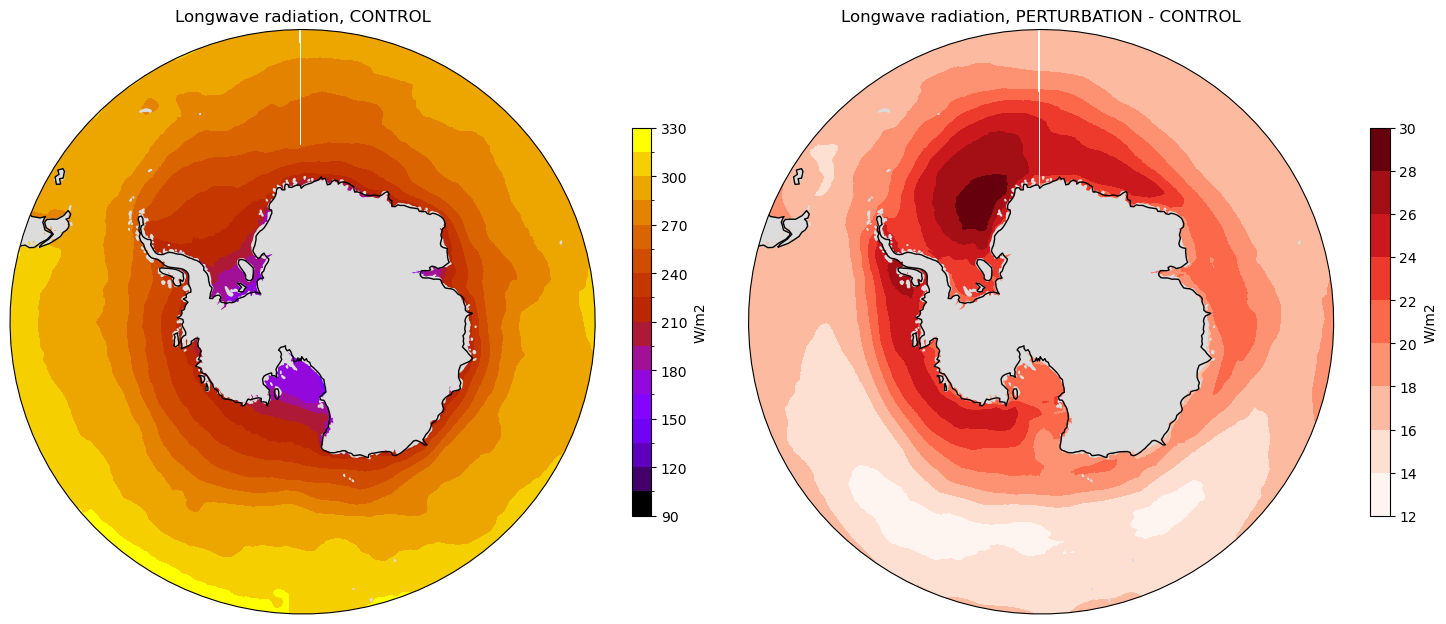

In [27]:
fig = plt.figure(figsize = (15, 10))
axs = [fig.add_subplot(121, projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(122, projection = ccrs.SouthPolarStereo())]
for ax in axs:
    ax = stereographic_axis(ax)

control['rlds'].mean('time').plot.contourf(ax = axs[0], levels = 20,
                                          cmap = 'gnuplot', transform = ccrs.PlateCarree(),
                                          cbar_kwargs = {'label':'W/m2', 'shrink':0.4})
axs[0].set_title('Longwave radiation, CONTROL');

(perturbation['rlds']-control['rlds']).mean('time').plot.contourf(ax = axs[1], levels = 10,
                                                                  cmap = 'Reds', transform = ccrs.PlateCarree(),
                                                                  cbar_kwargs = {'label':'W/m2', 'shrink':0.4})
axs[1].set_title('Longwave radiation, PERTURBATION - CONTROL');

plt.tight_layout();

#### Question 3

What do you think the changes to incoming longwave radiation are due to? How are these and the surface temperature changes related?

*Answer here*

Finally, let's look at the precipitation changes. We will include liquid precipitation (rain) and solid precipitation (snow).

In [22]:
precip_control = control['prrn'] + control['prsn']
precip_perturbation = perturbation['prrn'] + perturbation['prsn']

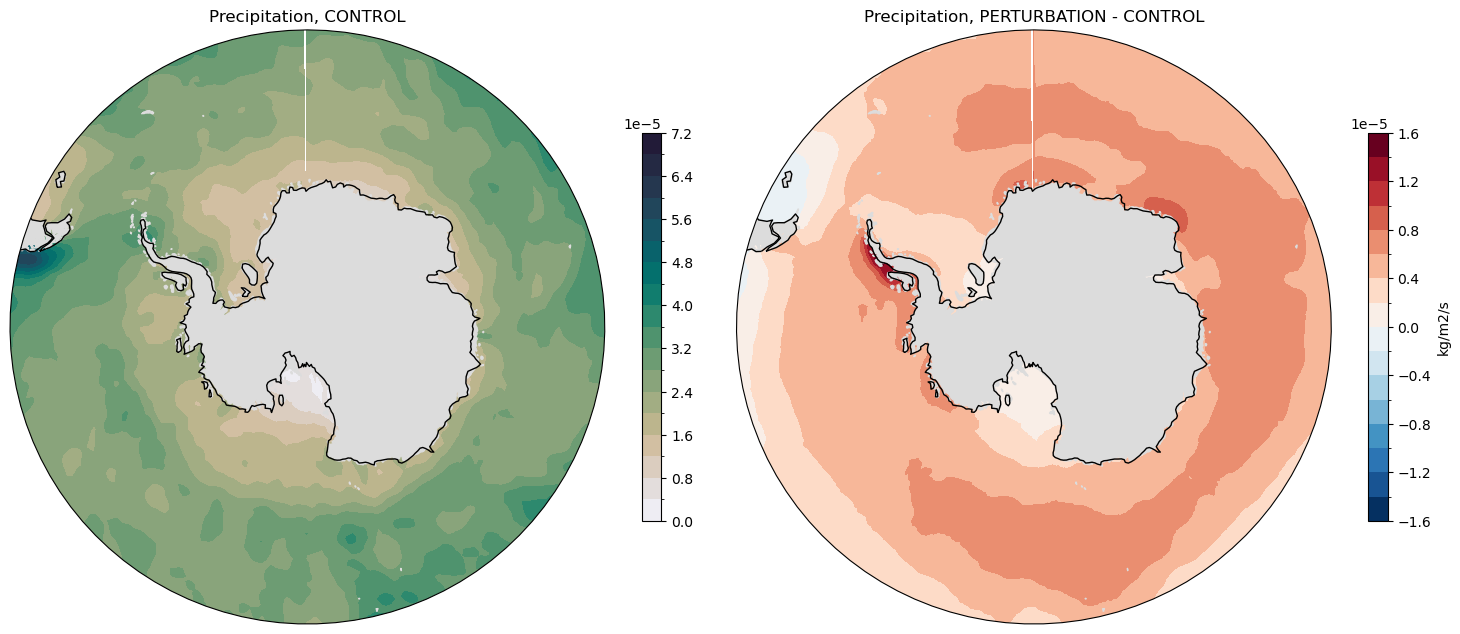

In [32]:
fig = plt.figure(figsize = (15, 10))
axs = [fig.add_subplot(121, projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(122, projection = ccrs.SouthPolarStereo())]
for ax in axs:
    ax = stereographic_axis(ax)

precip_control.mean('time').plot.contourf(ax = axs[0], levels = 20,
                                          cmap = cm.cm.rain, transform = ccrs.PlateCarree(),
                                          cbar_kwargs = {'label':'', 'shrink':0.4})
axs[0].set_title('Precipitation, CONTROL');

(precip_perturbation-precip_control).mean('time').plot.contourf(ax = axs[1], levels = 20,
                                                                cmap = 'RdBu_r', transform = ccrs.PlateCarree(),
                                                                cbar_kwargs = {'label':'kg/m2/s', 'shrink':0.4})
axs[1].set_title('Precipitation, PERTURBATION - CONTROL');

plt.tight_layout();

#### Question 4

Using the plots above, summarise the changes applied to the forcing fields used to run the perturbation experiments. Remember that the changes are representative of future projections for a SSP585 scenario in CMIP6 models.

*Answer here*

#### Question 5

We have looked at the changes in the time mean forcing fields. Explore the seasonality of the changes. For example:

 - Compare changes in wind strength changes between summer and winter.
 - Surface temperatures - are they changing more in a given season?
 - Same with precipitation.

*Answer here*